# Synthetic Air Transportation Traffic Data Generation

This notebook endeavors to generate some synthetic air transportation traffic data for an AWS blog post. This notebook uses the following design ideas about data generation.

1. Use all major large airport in the world.
2. Allow any airport pair to have cargo demands.
3. Add airlines between some airports. Airlines follow rules:
    - The number of airlines are proportion to the number of airports in a country;
    - An airline only has a few airport-airport flights;
    - Half of airlines in one country will have international flights, while another half only have domestic fligths.
4. The time unit is one day.
5. The routing policy is that we evenly distribute cargo demands between two airports through all available routes (shortest path).
6. The capacity of an airport is the sum of all outgoing flights' capacity per day.
7. Always use shortest path for traffic distribution.
8. A constant delay between actual traffic and demands, i.e., demands come first and then deliver after.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
%pip install geopandas
%pip install cartopy
%pip install pandas
%pip install numpy
%pip install networkx
%pip install matplotlib

In [5]:
import math

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy import crs as ccrs
from cartopy.io import shapereader

In [6]:
# Set up the total days for generating data
NUM_DEMAND_DAYS = 31
np.random.seed(47)

## Extract Major Airports in the World

In [7]:
# Fetch a list of N airport codes (three letter IATA codes) and their lat, lon coordinates
def fetch_airports_data(N=100):
    # You can use a public CSV file with airport data
    path = 'https://ourairports.com/data/airports.csv'

    airports = pd.read_csv(path)

    # Process `continent` column to replace NaN with string NA
    airports['continent'].fillna('NA', inplace=True)

    # filter out valid major airports in the world
    airports = airports[(airports['type'] == 'large_airport') & \
                        airports['iata_code'].notna() & \
                        airports['iso_country'].notna()]

    # Select only the first N airports and relevant columns
    selected_airports = airports[['iata_code', 'name', 'continent', 'iso_country', 'latitude_deg', 'longitude_deg']].head(N)
    return selected_airports

In [8]:
# Extract first 1000 major airports
airports_df = fetch_airports_data(N=1000)

# Turns out there are only 471 major airports
print(airports_df.shape)

(472, 6)


In [9]:
# Create a Networkx graph where nodes are the airports, and edges are demands between any two airports.
def create_airport_graph(airports_df):
    G = nx.Graph()

    # Add nodes
    for _, row in airports_df.iterrows():
        G.add_node(row['iata_code'], pos=(row['longitude_deg'], row['latitude_deg']))

    # Create edges between any two airports but not self loop
    np.random.seed(42)  # For reproducibility
    for i, source in enumerate(airports_df['iata_code']):
        for j, target in enumerate(airports_df['iata_code']):
            if i != j:  # Avoid self-loops and duplicate edges
                G.add_edge(source, target)
    return G

In [10]:
G = create_airport_graph(airports_df)

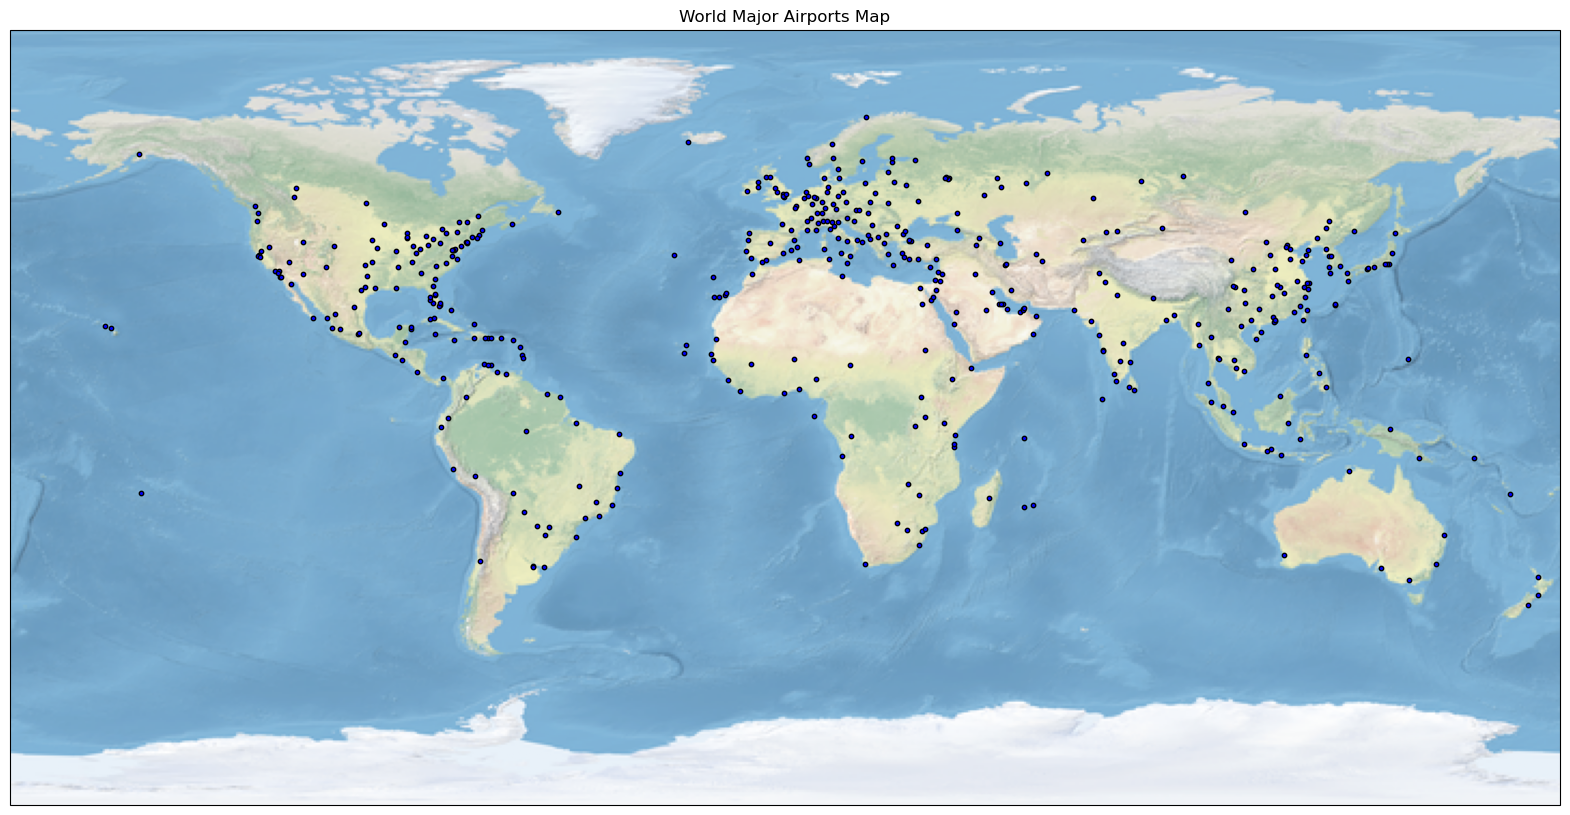

In [11]:
# Plot the airports only on a world map
def plot_graph(G, title, draw_edges=False):
    fig, ax = plt.subplots(figsize=(20, 14), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    # Add the world background map
    ax.stock_img()

    # Get the node positions (longitude, latitude)
    pos = nx.get_node_attributes(G, 'pos')

    # Plot nodes (metros/airports)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', ax=ax, edgecolors='k')

    # Plot edges (connections between metros)
    if draw_edges:
        edges = G.edges(data=True)
        for edge in edges:
            src, dst, data = edge
            coord_src = pos[src]
            coord_dst = pos[dst]
            ax.plot([coord_src[0], coord_dst[0]], [coord_src[1], coord_dst[1]], 
                    color='m', linestyle='-', linewidth=1, alpha=0.075)

    # plt.title("Airports Network with Connections")
    plt.title(title)

    plt.show()

plot_graph(G, title="World Major Airports Map")

## Create fully connected airport pairs for demand generation

In [12]:
airport_simple_df = airports_df[['iata_code', 'continent', 'iso_country']]

In [13]:
# create fully connected airport pairs
airports = airport_simple_df.iata_code.to_numpy().tolist()

num_aps = len(airports)
src_aps = []
dst_aps = []
for i, airport in enumerate(airports):
    src_aps += [airport] * (num_aps - 1)
    dst_ap = airports[:i] + airports[i+1:]
    dst_aps += dst_ap

airport_pair_full_df = pd.DataFrame({'src': src_aps, 'dst': dst_aps})
print(airport_pair_full_df.shape)

(222312, 2)


In [14]:
# add source and destination countries
airport_pair_full_df = pd.merge(airport_pair_full_df, airports_df[['iata_code', 'iso_country']], how='left',
                                left_on='src', right_on='iata_code')
airport_pair_full_df = pd.merge(airport_pair_full_df, airports_df[['iata_code', 'iso_country']], how='left',
                                left_on='dst', right_on='iata_code')
airport_pair_full_df.rename(columns={'iso_country_x': 'iso_country_src', 'iso_country_y': 'iso_country_dst'},
                            inplace=True)
airport_pair_full_df = airport_pair_full_df[['src', 'dst', 'iso_country_src', 'iso_country_dst']]

## Create airlines

In [15]:
country_df = airports_df.groupby(by=['iso_country'])['name'].count().sort_values(ascending=False)
country_df = country_df.reset_index()
country_df.rename(columns={'name':'cnt'}, inplace=True)
print(country_df.shape)

(161, 2)


In [16]:
# Set the proportion ratio of the number of airlines to the number of aiports
airline_to_country_ratio = 0.15

country_df['airline'] = country_df.apply(lambda x: [x.iso_country + '_AL' + str(i+1) \
                                                    for i in range(math.ceil(x.cnt * airline_to_country_ratio))], axis=1)

In [17]:
airlines_by_country = country_df.airline.to_numpy()

airlines = []
for al_country in airlines_by_country:
    airlines += al_country

print(f'There are totally {len(airlines)} airlines generated.')

There are totally 191 airlines generated.


## Create flights for airlines

We use the following design ideas of creating flights.

1. Each airline choose one "hub" airport as its main base.
2. Roll a 1/0 dice to determine if the airline can have international flights.
3. From the hub airport pick a one-hop airport as destination. If got 0 in the step 2, can only pick a domestic airport; if got 1, can pick any international airport.
4. Assign the capacity of the flight. A capacity is the number of flights per day, from 0 to 4 for domestic flights, or 0 to 1 for international flights. It could be a decimal, e.g., 0.5 means 1 fly per two days.
5. If the one-hop destination is a domestic one, pick another domestic destination and form a new flight between them.

In [18]:
def generate_num_flight_per_airline(num_airports, flight_per_day=2):
    """
    Use the flight per day for one airline to compute the number flights for an airline.
    Also depends on the number of airports in a country.
    """
    power_ratio = 0
    if num_airports < 2**0:
        power_ratio = 0
    elif num_airports >= 2**0 and num_airports < 2**1:
        power_ratio = 1
    elif num_airports >= 2**1 and num_airports < 2**2:
        power_ratio = 1
    elif num_airports >= 2**2 and num_airports < 2**3:
        power_ratio = 2
    elif num_airports >= 2**3 and num_airports < 2**4:
        power_ratio = 2
    elif num_airports >= 2**4 and num_airports < 2**6:
        power_ratio = 3
    elif num_airports >= 2**5 and num_airports < 2**6:
        power_ratio = 3
    else:
        power_ratio = 4

    portional_flight_per_day = flight_per_day * power_ratio

    num_flights = portional_flight_per_day * num_airports
    return num_flights

In [19]:
def generate_capacity(row):
    domestic_capacities = [0.125, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    intl_capacities = [0.125, 0.5, 1]

    if row.iso_country_src == row.iso_country_dst:
        capacity = np.random.choice(domestic_capacities, 1)[0]
    else:
        capacity = np.random.choice(intl_capacities, 1)[0]

    return capacity

In [20]:
def generate_flights(al_country, hub, is_intl, airport_pair_full_df, num_flights):
    """ Generate flights for an airline.

    Use a simple design:
    1. if domestic only, half flights will be one-hop and another half will be two-hop.
    2. if international, half flights will be one-hop domestic, quarter flights will be two-hop domestics, and the
       rest quarter will be international.
    Return
    -------
    flight_df: DataFrame
        A dataframe with 4 columns, fligt_num, src, dst, capacity
    """
    domestic_pair = airport_pair_full_df[(airport_pair_full_df.iso_country_src == al_country) &
                                         (airport_pair_full_df.iso_country_dst == al_country)]
    domestic_one_hop = domestic_pair[domestic_pair.src == hub]
    international_pair = airport_pair_full_df[(airport_pair_full_df.src == hub) &
                                              (airport_pair_full_df.iso_country_dst != al_country)]

    # Sepcial case, only one aiport in a country. So only international flights
    if domestic_pair.shape[0] == 0:
        flights = international_pair.sample(num_flights)
        flights['flight_num'] = np.arange(1, flights.shape[0]+1)
        flights['capacity'] = flights.apply(generate_capacity, axis=1)

        return flights

    # one-hop domestic flights
    half_num_flights = math.ceil(num_flights * 0.5)
    one_hop_flights = domestic_one_hop.sample(n=half_num_flights, replace=True)

    # international flights
    another_half_num_flights = num_flights - half_num_flights
    third_quarter_num_flights = math.ceil(another_half_num_flights * 0.5)

    intl_flights = pd.DataFrame({'src': [], 'dst': [], 'iso_country_src': [], 'iso_country_dst': []})

    if is_intl:
        intl_flights = international_pair.sample(third_quarter_num_flights)
        rest_num_flights = another_half_num_flights - third_quarter_num_flights
        two_hop_flights = pd.merge(one_hop_flights, domestic_pair,
                                   how='inner', left_on='dst',
                                   right_on='src').sample(rest_num_flights, replace=True)
    else:
        two_hop_flights = pd.merge(one_hop_flights, domestic_pair,
                                   how='inner', left_on='dst',
                                   right_on='src').sample(another_half_num_flights, replace=True)

    two_hop_flights = two_hop_flights[['src_y', 'dst_y', 'iso_country_src_y', 'iso_country_dst_y']]
    two_hop_flights = two_hop_flights.rename(columns={'src_y':'src', 'dst_y': 'dst',
                                                      'iso_country_src_y': 'iso_country_src',
                                                      'iso_country_dst_y': 'iso_country_dst'})

    flights = pd.concat([one_hop_flights, two_hop_flights, intl_flights])

    # remove duplicate flights. All flights are round trips, so should no hub in dst column
    flights = flights[flights.dst != hub]

    flights['flight_num'] = np.arange(1, flights.shape[0]+1)

    flights['capacity'] = flights.apply(generate_capacity, axis=1)

    return flights

In [21]:
all_flight_list = []

for al in airlines:
    al_country = al[:2]

    country_aps = airports_df[airports_df.iso_country == al_country].iata_code.to_numpy()
    ap_cnt = country_aps.shape[0]
    is_intl = np.random.choice([0, 1], p=[0.5, 0.5]) if ap_cnt > 1 else 0

    al_hub = np.random.choice(country_aps, 1)[0]

    num_flights = generate_num_flight_per_airline(ap_cnt)

    al_flights = generate_flights(al_country, al_hub, is_intl, airport_pair_full_df, num_flights)

    al_flights['flight_num'] = al + '_' + al_flights['flight_num'].astype(str)

    all_flight_list.append(al_flights)

all_flights = pd.concat(all_flight_list)

# to build bi-directional flights, capacity should be divided by 2
all_flights['capacity'] = all_flights['capacity'] / 2

In [22]:
print(f'Total capacity in the world: {all_flights.capacity.sum()} by {all_flights.shape[0]} flights.')

Total capacity in the world: 8325.0 by 9269 flights.


In [23]:
all_flights_rev = all_flights[['dst', 'src', 'iso_country_dst', 'iso_country_src', 'flight_num', 'capacity']]
all_flights_rev.rename(columns={'dst':'src', 'src': 'dst',
                                'iso_country_dst': 'iso_country_src', 'iso_country_src': 'iso_country_dst'}, inplace=True)
all_flights_rev['flight_num'] = all_flights_rev['flight_num'] + '_rev'

In [24]:
all_flights_full = pd.concat([all_flights, all_flights_rev])
print(f'Total capacity in the world: {all_flights_full.capacity.sum()} for {all_flights_full.shape[0]} flights')

Total capacity in the world: 16650.0 for 18538 flights


### Visualize world flights map

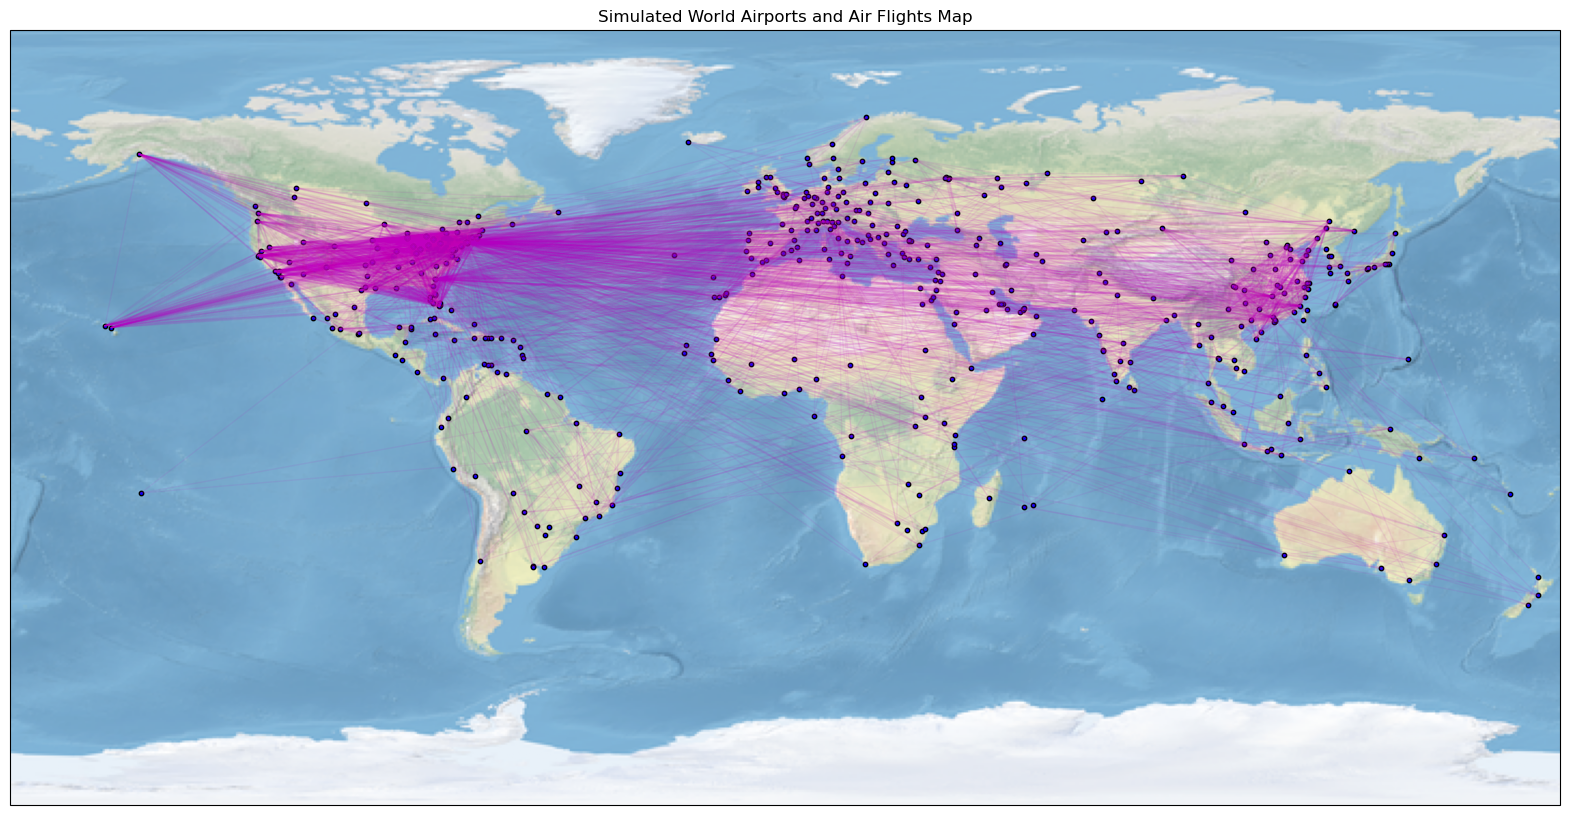

In [25]:
flight_G = nx.Graph()

ap_codes = []
nids = []
# Add nodes from airports_df
for _, row in airports_df.iterrows():
    ap_codes.append(row['iata_code'])
    flight_G.add_node(row['iata_code'], pos=(row['longitude_deg'], row['latitude_deg']))

# Create edges based on generated flights
for _, row in all_flights_full.iterrows():
    flight_G.add_edge(row['src'], row['dst'], capacity=row['capacity'])

plot_graph(flight_G, title="Simulated World Airports and Air Flights Map", draw_edges=True)

## Generate airport to airport demands

We generate demands between any two airports based on the following design ideas.

1. Use day as time unit of demand to match the flight capacity time unit.
2. Dometics demands are four times larger than the international demands, following the same pattern as flights' capacities.
3. Demands have weekly patterns and some random variances. So far, no seasonal patterns.
4. Set up demands to be smaller than the total capability of flights, so that all demands can be handled in some days.

In [26]:
def generate_demand_timeseries(top, scale=1, n_days=365):
    # Create a combination of sinusoids to simulate daily demand with weekly pattern
    assert top >= scale
    days = np.arange(n_days)
    weekly_demand = np.clip(scale * (np.sin(2 * np.pi * days / 7) + (top - scale)) + np.random.normal(-scale, scale, n_days),
                            a_min=0, a_max=top)
    # remove very small demands to avoid nearly 0 paylod
    weekly_demand = np.round(weekly_demand, 2)
    return weekly_demand

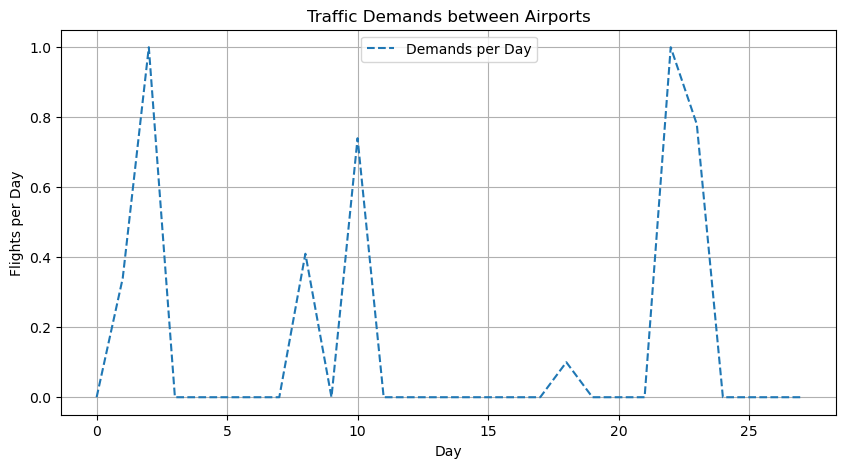

In [27]:
# Test the above function
demands = generate_demand_timeseries(top=1, scale=0.5, n_days=28)

# Bonus: plot a timeseries for one of the airport pairs
def plot_demand_timeseries(demands):
    plt.figure(figsize=(10, 5))
    plt.plot(demands, label='Demands per Day', linestyle='--')
    plt.title(f'Traffic Demands between Airports')
    plt.xlabel('Day')
    plt.ylabel('Flights per Day')
    plt.legend()
    plt.grid(True)
    plt.show()
# visualize the pattern for better understanding
plot_demand_timeseries(demands)

In [28]:
def get_ratio(num_airports, scale=1):
    power_ratio = 0
    if num_airports < 2**0:
        power_ratio = 0
    elif num_airports >= 2**0 and num_airports < 2**1:
        power_ratio = 1
    elif num_airports >= 2**1 and num_airports < 2**2:
        power_ratio = 1
    elif num_airports >= 2**2 and num_airports < 2**3:
        power_ratio = 2
    elif num_airports >= 2**3 and num_airports < 2**4:
        power_ratio = 2
    elif num_airports >= 2**4 and num_airports < 2**6:
        power_ratio = 3
    elif num_airports >= 2**5 and num_airports < 2**6:
        power_ratio = 3
    else:
        power_ratio = 4

    return math.ceil(power_ratio * scale)


def generate_pair_demands(src_cn, dst_cn, n_days, num_aps_dict):
    """ Generate demands for all airport pairs with given number of days.

    The demands should follow the 3 rules:
    1. demands are propotional to the number of airports in a country;
    2. demands for domestic pairs is 4 times of international pairs;
    3. the number of airports will determine the arguments of generate_demand_timeseries(), top and scale.
    """
    # src_cn = row['iso_country_src']
    # dst_cn = row['iso_country_dst']
    num_aps = num_aps_dict[src_cn]
    if src_cn == dst_cn:    # a domestic pair
        power_ratio = get_ratio(num_aps, scale=0.5)
    else:                   # an international pair
        power_ratio = get_ratio(num_aps, scale=0.125)

    demands = generate_demand_timeseries(top=power_ratio, scale=1, n_days=n_days)

    return demands

In [29]:
num_aps_dict = {}
for _, row in country_df.iterrows():
    num_aps_dict[row['iso_country']] = row['cnt']

Now generate demands for all airport pairs

In [30]:
airport_pair_full_df['demands'] = airport_pair_full_df.apply(lambda 
                                                             row: generate_pair_demands(row['iso_country_src'], row['iso_country_dst'], NUM_DEMAND_DAYS, num_aps_dict),
                                                             axis=1)

In [31]:
# expend the list to multiple columns for later usage.
demands_df = pd.DataFrame(airport_pair_full_df.demands.to_list(), columns=['demand_d'+str(i) for i in range(NUM_DEMAND_DAYS)])
demands_df = pd.concat([airport_pair_full_df[['src', 'dst', 'iso_country_src', 'iso_country_dst']], demands_df], axis=1)

## Simulate Demand Fulfillment

We use a simple routing algorithm to simulate how to fulfill demands between airports.

1. Demands will be fulfilled in the next day.
2. Follow first come first serve policy.
3. If no flights available, store at airport as inventory to the the next day. And there is no limit of airport storage capacity so far.
4. Always use the shortest path to fulfill demands.
5. If there are multiple shortest paths for a demand, fulfill it with ALL shortest paths evenly.
6. In an airport, traffics will NOT be evenly distributed if there are multiple flights to the next stop. Always use one flight to carry a traffic. If not enough, take the rest traffic to the next flight until all flights occupied.

### A: Generate traffic router class

In [32]:
class Traffic():
    """
    """
    def __init__(self,
                 header,
                 payload):
        assert len(header) > 0, 'The header must contains at least one airport, ' + \
                                f'but got {header}.'
        self._header = header
        assert round(payload, 4) > 0, 'Payload should be a value greather than 0. ' + \
                                     f'but got to {header} with {payload}.'
        self._payload = round(payload, 4)

    def next_stop(self):
        if len(self._header) > 1:
            next_stop = self._header.pop(0)
        elif len(self._header) == 1:
            next_stop = self._header[0]
        else:
            next_stop = None
        return next_stop

    def is_final(self, airport=None):
        if airport is not None:
            return len(self._header) == 1 and self._header[0] == airport
        else:
            return len(self._header) == 1

    def get_header(self):
        """ Give a copy of the header to avoid mutation by others.
        """
        cp_header = [ap for ap in self._header]
        return cp_header

    def get_payload(self):
        return self._payload

    def set_payload(self, payload):
        assert payload > 0, 'Payload should be a value greather than 0.'
        self._payload = payload

    def to_string(self):
        return '(' + '->'.join(self._header) + ': ' + str(self._payload) + ')'


class AirportRouter():
    """ A router that simulate how to relay traffics

    Parameters
    ----------
    name: str
        Name of this airport.
    routing_tables: dict of list of lists
        Pre-computed shortest paths to other airports from this airport in the format of
        {dst: [[airport1, airport2, ...], [...]], dst: [[]]}
    flights_tables: dict of list of tuples
        Available connected airports with flights in the format of
        {dst: [(flight1, cap), (flight2, cap), ...], ...}
    """
    def __init__(self,
                 name,
                 routing_table,
                 flights_table):
        self.name = name
        self.routing_table = routing_table
        self.flights_table = flights_table
        self.stored_traffics = {}

    def to_string(self):
        """ Output stored traffics for easy debug.
        """
        outputs = ''
        for next_stop, next_stop_queue in self.stored_traffics.items():
            queue_outputs = [traffic.to_string() for traffic in next_stop_queue]
            next_stop_outputs = next_stop + ': ' + '\t'.join(queue_outputs)
            outputs += next_stop_outputs + '\n'
        return outputs

    def add_demand(self, dst, demand):
        """ Accept local demand to the destination airport.

        For the demand, extract the shortest paths from this airport to the dst airport.
        If only one path, create one traffic, whose header is the path, and payload is the
        demand number.
        If there are multiple paths, create multiple traffics, evenly distribute demands.
        """
        # The demand is too small, ignored...
        if demand < 0.001:
            return
        else:
            pre_demand = round(demand, 4)

        shortest_paths = self.routing_table[dst]

        ave_demand = round(demand/len(shortest_paths), 4)

        # if the demand is too small to be split, only use the first shortest path to deliver. 
        if ave_demand < 0.001:
            new_shortest_path = [airport for airport in shortest_paths[0]]
            traffic = Traffic(new_shortest_path, demand)

            # route this traffic in queue
            self._route_traffic(traffic)
        else:
            for shortest_path in shortest_paths:
                # copy the shortest path to avoid change the original
                new_shortest_path = [airport for airport in shortest_path]
                traffic = Traffic(new_shortest_path, ave_demand)

                # route this traffic in queue
                self._route_traffic(traffic)

    def add_traffics(self, traffics):
        """ Add incoming flight traffics.

        A traffic has a header and a payload.
        - The header contains a list of airports, indicating the next stops to send.
        - The payload is a number.

        In an incoming traffic, the first airport in the header should be same as this airport.
        When add a traffic, first get the first airport as the next stop from the header, and
        then check the next stop to relay this traffic. If no next stop, i.e., the traffic has
        reach its final destination, delete this traffic and no further action. If there is the
        next stop, add this traffic to the stored traffics under the same next stop airport.
        """
        for traffic in traffics:

            if traffic.is_final(self.name):
                del traffic
                continue
                # Comment out print claude to save spaces
                # print(f'The traffic {traffic.to_string()} arrives its final destination.')
            else:
                self._route_traffic(traffic)

    def _route_traffic(self, traffic):
        """ Take a traffic and route it to the correct queue for dispatch.
        """
        next_stop = traffic.next_stop()
        assert next_stop is not None, 'This is an invalid traffic or the traffic has reach its ' + \
                                      'final destionation'
        if self.stored_traffics.get(next_stop, None) is None:
            self.stored_traffics[next_stop] = [traffic]
        else:
            next_stop_queue = self.stored_traffics.get(next_stop)
            next_stop_queue.append(traffic)

    def dispatch_traffics(self):
        """ dispatch the stored traffics based on the airport's next stops.

        Iterate the stored_traffics. For each traffic, extract its next airport, and then check the
        flights_table to find out available flights. If there are available flights, evenly send out
        traffics to the next stops.
        """
        out_traffics = {}
        fulfilled_next_stops = []

        for next_stop, next_stop_queue in self.stored_traffics.items():

            new_next_stop_queue = []

            # extract available flights by making copeis, so that later operation will not modify the
            # predefined flight table.
            flights = [(flight, capacity) for (flight, capacity) in self.flights_table[next_stop]]

            while len(next_stop_queue) > 0:
                traffic = next_stop_queue.pop(0)
                payload = traffic.get_payload()
                while len(flights) > 0:
                    flight, capacity = flights.pop(0)
                    if payload > capacity:    # this flight is not enough
                        new_payload = round(capacity, 4)
                        if new_payload > 0.001:
                            out_traffic = Traffic(traffic.get_header(), new_payload)
                            new_next_stop_queue.append(out_traffic)
                        payload = round((payload - capacity), 4)
                        if payload < 0.001:
                            break
                    elif payload == capacity:
                        new_payload = round(payload, 4)
                        if new_payload > 0.001:
                            out_traffic = Traffic(traffic.get_header(), new_payload)
                            new_next_stop_queue.append(out_traffic)
                        else:
                            payload = 0
                        break
                    else:                      # this flight has redundent capacity
                        new_payload = round(payload, 4)
                        if new_payload > 0.001:
                            out_traffic = Traffic(traffic.get_header(), new_payload)
                            new_next_stop_queue.append(out_traffic)
                        rest_capacity = round((capacity - new_payload), 4)
                        if rest_capacity > 0.001:
                            flights = [(flight, rest_capacity)] + flights
                        else:
                            payload = 0
                        break
                # All flights can not deliver stored queue, and the rest payload is big enough
                if payload > 0.:
                    traffic.set_payload(payload)
                    next_stop_queue.insert(0, traffic)    # use the original pointer of this list
                    break
            # add new queue to out traffics
            if new_next_stop_queue:
                out_traffics[next_stop] = new_next_stop_queue
            # check if the queue is fulfilled
            if not next_stop_queue:
                fulfilled_next_stops.append(next_stop)

        # clean up fufilled next stops
        for next_stop in fulfilled_next_stops:
            del self.stored_traffics[next_stop]

        return out_traffics

    def current_inventory_amount(self):
        """ The current inventory total amount.
        """
        inventory_amount = 0
        for _, next_stop_queue in self.stored_traffics.items():
            for traffic in next_stop_queue:
                inventory_amount += traffic.get_payload()

        return inventory_amount

### B: Generate airline flight network's routing table and flight table

Use the `all_flights_full` dataframe and `flight_G` graph to create the two tables for all airports.
- routing table: records all the shortest paths between any pair of airports.
- flight table: records the destination and flights for any airport.

In [33]:
all_routing_table = {}

for src, dst_paths in dict(nx.all_pairs_all_shortest_paths(flight_G)).items():
    routing_table = {}
    for dst, paths in dst_paths.items():
        if src == dst:
            continue
        # remove the src from all path
        new_paths = [path[1:] for path in paths]
        routing_table[dst] = new_paths

    all_routing_table[src] = routing_table


In [34]:
total_num_aps = len(all_routing_table)
print(total_num_aps)

# sanity check
for src, paths in all_routing_table.items():
    num_dsts = len(paths)
    if num_dsts != total_num_aps - 1:
        print(f'Source airport {src} can not reach to all airports, but {num_dsts}...')

472


In [35]:
all_flights_full['flights'] = list(zip(all_flights_full.flight_num, all_flights_full.capacity))

pair_flights = all_flights_full.groupby(by=['src', 'dst'])['flights'].apply(list).reset_index(name='flights')
airport_flights = pair_flights.groupby(by=['src']).agg(list)
airport_flights.reset_index(inplace=True)

In [36]:
all_flights_table = {}

for _, row in airport_flights.iterrows():
    src = row['src']
    dst_list = row['dst']
    flights_list = row['flights']
    # sanity check
    if len(dst_list) != len(flights_list):
        print(f'Invalid row: {row}')

    dst_flights = {}
    for dst, flights in zip(dst_list, flights_list):
        dst_flights[dst] = flights

    all_flights_table[src] = dst_flights

In [37]:
# sanity check
assert len(all_routing_table) == len(all_flights_table)

### C: Create utility functions
----
1. a function to initialize all airport with routing tables and flight tables.

In [38]:
def initialize_airports(all_routing_table, all_flights_table):
    airport_list = {}

    for src, routing_table in all_routing_table.items():
        airport_router = AirportRouter(src, routing_table, all_flights_table[src])
        airport_list[src] = airport_router
    return airport_list

2. a function to add local demands.

In [39]:
def add_current_demands(airport_list, current_demands):
    airports = []
    inventory_amount_list = []
    for _, row in current_demands.iterrows():
        src = row['src']
        airport_router = airport_list[src]

        demand_list = row['current_demand']
        for dst, demand in demand_list:
            airport_router.add_demand(dst, demand)

        airports.append(src)
        inventory_amount_list.append(airport_router.current_inventory_amount())

    current_airport_inventory_df = pd.DataFrame({
        'iata_code': airports,
        'inventory_amount': inventory_amount_list
    })

    return current_airport_inventory_df

3. a function to dispatch demands (local + through traffics) as traffics

In [40]:
def dispatch_demands(airport_list):
    """ Dispatch demands in all airports

    Return: a dict of list of traffics as inputs of adding traffics to all airports.
    """
    dst_ap_traffics = {}
    ap2ap_traffics = {}
    for src_ap, airport_router in airport_list.items():
        output_traffics = airport_router.dispatch_traffics()
        for next_stop_ap, traffics in output_traffics.items():
            # extract destination airport based traffics
            if dst_ap_traffics.get(next_stop_ap, None) is None:
                dst_ap_traffics[next_stop_ap] = traffics
            else:
                existing_traffics = dst_ap_traffics[next_stop_ap]
                dst_ap_traffics[next_stop_ap] = existing_traffics + traffics

            # extract pair-wised traffics
            if ap2ap_traffics.get((src_ap, next_stop_ap), None) is None:
                ap2ap_traffics[(src_ap, next_stop_ap)] = traffics
            else:
                existing_traffics = ap2ap_traffics[(src_ap, next_stop_ap)]
                ap2ap_traffics[(src_ap, next_stop_ap)] = existing_traffics + traffics

    return dst_ap_traffics, ap2ap_traffics

### D: Simulate all local demands adding and traffic dispatching

In [43]:
# intialize all airport routers
airports = initialize_airports(all_routing_table, all_flights_table)
print(f'Total have {len(airports)} airports.')

Total have 472 airports.


In [44]:
inventory_list = []
ap2ap_traffics_df_list = []

for ts_day in range(NUM_DEMAND_DAYS):
    # extract the current day demands
    demand_current_ts = 'demand_d' + str(ts_day)
    # print(f'\n================ Process and Add Day {ts_day} Demands and Dispatch ==================')
    demands_df['current_demand'] = list(zip(demands_df.dst, demands_df[demand_current_ts]))
    current_demands = demands_df.groupby(by=['src'])['current_demand'].apply(list).reset_index(name='current_demand')

    # add current demands to all airports before dispatching traffics
    current_inventory_df = add_current_demands(airports, current_demands)
    current_inventory_df.rename(columns={'inventory_amount': 'inventory_amount_d'+str(ts_day)}, inplace=True)
    inventory_list.append(current_inventory_df)

    # dispatch demands to world wide airports
    dst_ap_traffics, ap2ap_traffics = dispatch_demands(airports)

    # collecting ap2ap traffic volume as edge ts features
    src_list = []
    dst_list = []
    traffic_payload_list = []
    for (src, dst), traffics in ap2ap_traffics.items():
        src_list.append(src)
        dst_list.append(dst)
        total_payload = 0
        for traffic in traffics:
            total_payload += traffic.get_payload()
        traffic_payload_list.append(total_payload)
    ap2ap_traffics_df = pd.DataFrame({
        'src': src_list,
        'dst': dst_list,
        'traffic_payload_d'+str(ts_day): traffic_payload_list
    })
    ap2ap_traffics_df_list.append(ap2ap_traffics_df)

    # add traffics to all airports
    for dst_ap, traffics in dst_ap_traffics.items():
        dst_airport_router = airports[dst_ap]
        dst_airport_router.add_traffics(traffics)


## Save generated air transportation traffic data to local files.

---

### Build node data tables

For simplicity, we only use airports as nodes, i.e., one node type. Static node features are in `airports_df`, while dynamic (time series) airport features are the inventory ammount collected in `inventory_list`.

In [45]:
airport_node_df = airports_df[['iata_code', 'latitude_deg', 'longitude_deg']]

for d, current_inventory_df in enumerate(inventory_list):
    current_inventory_df.rename(columns={'inventory_amount': 'inventory_amount_'+str(d)}, inplace=True)
    airport_node_df = pd.merge(airport_node_df, current_inventory_df, how='inner', on='iata_code')

print(airport_node_df.shape)

airport_node_df['inventory_amounts'] = airport_node_df[['inventory_amount_d'+str(d) for d in range(NUM_DEMAND_DAYS)]].values.tolist()
airport_node_df['inventory_amounts'] = airport_node_df['inventory_amounts'].apply(lambda x: [round(v, 4) for v in x])

(472, 34)


In [46]:
# Save the node table to a local parquet file
airport_node_df[['iata_code', 'latitude_deg', 'longitude_deg', 'inventory_amounts']].to_parquet('airport.parquet', index=False)

### Build edge data tables

Based on the airport traffics, we have two types of messages moving around airports.

1. Airport to airport demands, which form a fully connected graph among all airports. Therefore, the edge list contains all pair-wised connections between any two airports. And the edge features are demand numbers between these pairs. If there is no demand in a day, its value should be 0. In addition, for GNN message passing, we need to reverse the src and dst in this edge type so that demand information can be passed to the src airport and then pass through flights as traffics. This edge table is from `airport_pair_full_df`.
2. Airport to airport traffics, which are based on the actual flight connections. Therefore, it only contains airport pairs that have flights connected. This data could be from `ap2ap_traffics_df_list` and `all_flights_full`. If there is no traffic is a day, its value should be 0.

In [55]:
# demand edge list
demand_edge_df = airport_pair_full_df[['dst', 'src', 'demands']]

#reverse the demand edge direction
demand_edge_df.rename(columns={'dst': 'src_code', 'src': 'dst_code'}, inplace=True)

In [48]:
# save demand edge table to a local parquet file
demand_edge_df.to_parquet('demand_edge.parquet', index=False)

In [49]:
# traffic edge list
traffic_edge_df = pd.DataFrame(all_flights_full.groupby(by=['src', 'dst'])['capacity'].sum())
traffic_edge_df.reset_index(inplace=True)

In [50]:
for ap2ap_traffic_df in ap2ap_traffics_df_list:
    traffic_edge_df = pd.merge(traffic_edge_df, ap2ap_traffic_df, how='left', on=['src', 'dst'])

In [51]:
# replace nan to 0
traffic_edge_df.fillna(0, inplace=True) 
traffic_edge_df.rename(columns={'src': 'src_code', 'dst': 'dst_code'}, inplace=True)

In [53]:
# merge multiple columns into one column of list
traffic_edge_df['traffics'] = traffic_edge_df[['traffic_payload_d'+str(d) for d in range(NUM_DEMAND_DAYS)]].values.tolist()

In [54]:
# save traffic edge table to a local parquet file
traffic_edge_df[['src_code', 'dst_code', 'capacity', 'traffics']].to_parquet('traffic_edge.parquet', index=False)